# EOSC 213 — Lecture 12 - Implementation of System of ODEs (Linear systems, eigenvalues, phase portraits, and stability)

This notebook connects the math from **Lectures 10–11** to hands-on coding.

You will:
1. Start from a **component-wise system** and rewrite it as a **linear system**  $\mathbf{x}'(t)=A\mathbf{x}(t)$
2. Visualize dynamics using **vector fields** and **phase portraits** (trajectories).
3. Compute **eigenvalues/eigenvectors** of $A$ using PyTorch.
4. Implement **Forward Euler (FE)**, **Explicit Midpoint (EM)**, and **Backward Euler (BE)** for systems.
5. Study **numerical stability** using **amplification matrices** and **stability regions**.

> Tip: Run cells top-to-bottom. Modify parameters and re-run to explore.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
torch.random.seed(0)

## 0) Helper utilities (plotting + simulation)

We will work mainly with **2D linear systems**:

$$\mathbf{x}' = A\mathbf{x}, \quad \mathbf{x}=\begin{bmatrix}x\\y\end{bmatrix}, \quad
A\in\mathbb{R}^{2\times2}.
$$

We’ll implement:
- vector field plotting
- trajectory simulation (FE / EM / BE)
- phase portrait plotting (many initial conditions)

In [13]:
def vector_field(A, xlim=(-2, 2), ylim=(-2, 2), n=25):
    # Returns meshgrid (X,Y) and vector field components (U,V) for x_dot = A x.
    xs = torch.linspace(xlim[0], xlim[1], n)
    ys = torch.linspace(ylim[0], ylim[1], n)
    X, Y = torch.meshgrid(xs, ys, indexing='xy')
    U = A[0, 0] * X + A[0, 1] * Y
    V = A[1, 0] * X + A[1, 1] * Y
    return X, Y, U, V

def plot_vector_field(A, title="", xlim=(-2, 2), ylim=(-2, 2), n=25):
    X, Y, U, V = vector_field(A, xlim, ylim, n)
    plt.figure(figsize=(6, 6))
    plt.quiver(X, Y, U, V)
    plt.axhline(0, linewidth=0.8)
    plt.axvline(0, linewidth=0.8)
    plt.xlim(*xlim); plt.ylim(*ylim)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.xlabel("x"); plt.ylabel("y")
    plt.title(title)
    plt.show()

def simulate_linear(A, x0, h=0.05, T=5.0, method="FE"):
    # Simulate x_dot = A x using FE / EM / BE.
    A = torch.as_tensor(A, dtype=torch.get_default_dtype())
    x = torch.as_tensor(x0, dtype=torch.get_default_dtype()).reshape(-1)
    d = x.numel()

    N = int(np.ceil(T / h))
    t = torch.linspace(0.0, N * h, N + 1)

    X = torch.zeros((N + 1, d), dtype=torch.get_default_dtype())
    X[0] = x

    I = torch.eye(d, dtype=torch.get_default_dtype())

    for n in range(N):
        if method == "FE":
            x = x + h * (A @ x)

        elif method == "EM":
            x_half = x + 0.5 * h * (A @ x)
            x = x + h * (A @ x_half)

        elif method == "BE":
            # (I - hA) x_{n+1} = x_n
            M = I - h * A
            x = torch.linalg.solve(M, x)

        else:
            raise ValueError("method must be one of: 'FE', 'EM', 'BE'")

        X[n + 1] = x

    return t, X.detach().cpu().numpy()

def plot_phase_portrait(A, initials, h=0.05, T=5.0, method="FE",
                        xlim=(-2, 2), ylim=(-2, 2), title=""):
    # Plot trajectories (phase portrait) for multiple initial conditions.
    plt.figure(figsize=(6, 6))
    for x0 in initials:
        t, X = simulate_linear(A, x0, h=h, T=T, method=method)
        plt.plot(X[:, 0], X[:, 1], linewidth=2)
        plt.scatter([X[0, 0]], [X[0, 1]], s=40)  # start point
    plt.axhline(0, linewidth=0.8)
    plt.axvline(0, linewidth=0.8)
    plt.xlim(*xlim); plt.ylim(*ylim)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.xlabel("x"); plt.ylabel("y")
    plt.title(title)
    plt.show()

def circle_initials(radius=1.5, k=10):
    angles = torch.linspace(0, 2 * torch.pi, k + 1)[:-1]
    return [torch.tensor([radius * torch.cos(a), radius * torch.sin(a)]) for a in angles]

## 1) From component-wise equations to matrix form

A *linear* 2D system can be written as
$$
\begin{aligned}
x' &= a_{11}x + a_{12}y,\\
y' &= a_{21}x + a_{22}y,
\end{aligned}
$$
which becomes
$$
\mathbf{x}' = A\mathbf{x},\quad
A=\begin{bmatrix}
a_{11} & a_{12}\\
a_{21} & a_{22}
\end{bmatrix}.
$$

We'll explore several eigenvalue cases:
- stable node, saddle
- spiral sink/source
- center (pure imaginary eigenvalues)

In [3]:
# Example matrices A (2D)

A_stable = torch.tensor([[-1.0,  0.0],
                         [ 0.0, -2.0]])

A_saddle = torch.tensor([[ 1.0,  0.0],
                         [ 0.0, -1.0]])

A_spiral_sink = torch.tensor([[-1.0, -3.0],
                              [ 3.0, -1.0]])

A_center = torch.tensor([[ 0.0,  1.0],
                         [-1.0,  0.0]])

examples = {
    "Stable node (both <0)": A_stable,
    "Saddle (one >0, one <0)": A_saddle,
    "Spiral sink (complex, Re<0)": A_spiral_sink,
    "Center (pure imaginary)": A_center,
}

## 2) Vector fields (direction field in phase space)

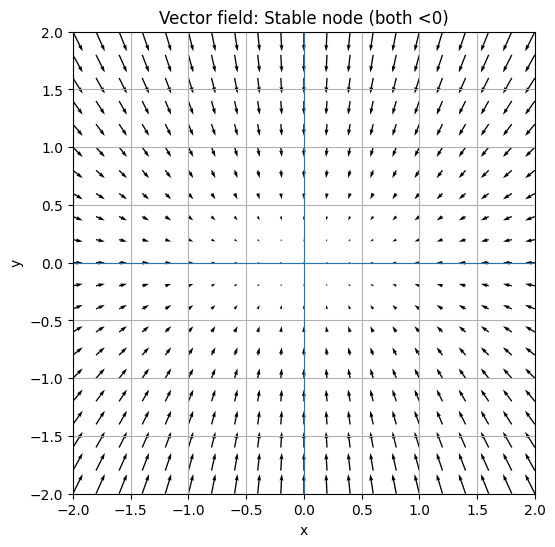

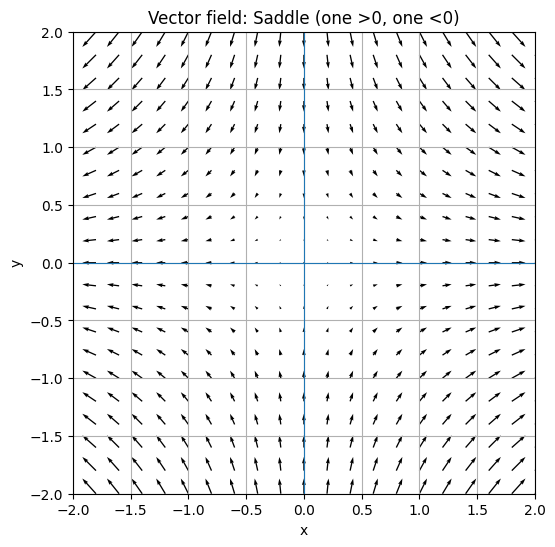

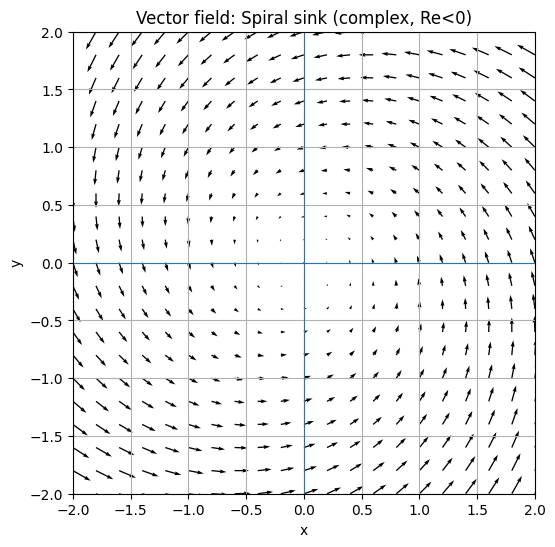

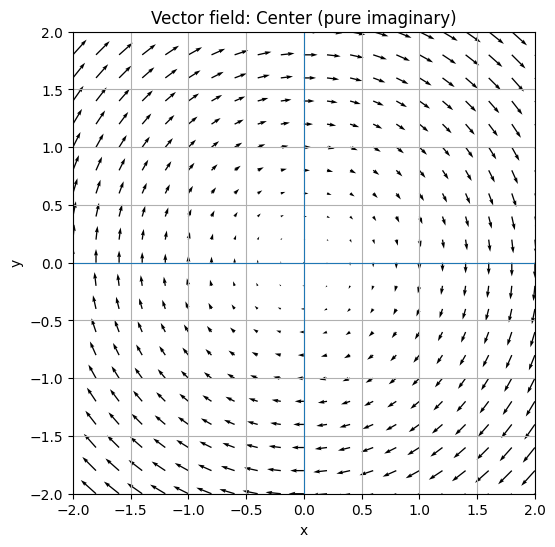

In [4]:
for name, A in examples.items():
    plot_vector_field(A.numpy(), title=f"Vector field: {name}", xlim=(-2, 2), ylim=(-2, 2), n=21)

## 3) Phase portraits (trajectories)

A phase portrait is made of **solution trajectories** plotted in the \((x,y)\)-plane.
Each curve corresponds to a different initial condition.

In [ ]:
inits = circle_initials(radius=1.8, k=10)

for name, A in examples.items():
    plot_phase_portrait(
        A.numpy(), initials=inits, h=0.02, T=6.0, method="FE",
        xlim=(-2.2, 2.2), ylim=(-2.2, 2.2),
        title=f"Phase portrait (FE trajectories): {name}"
    )

## 4) Eigenvalues (and eigenvectors) of $A$ with PyTorch

For $\mathbf{x}' = A\mathbf{x}$:
- $\Re(\lambda) < 0$: decay (stable)
- $\Re(\lambda) > 0$: growth (unstable)
- $\Im(\lambda)\neq 0$: oscillation/rotation

PyTorch:
- `torch.linalg.eig(A)` gives eigenvalues **and** eigenvectors
- `torch.linalg.eigvals(A)` gives eigenvalues only

In [6]:
def classify_eigs(eigs, tol=1e-10):
    eigs = torch.as_tensor(eigs)
    re = eigs.real
    im = eigs.imag

    if torch.all(torch.abs(im) < tol):  # real eigenvalues
        if torch.all(re < -tol):
            return "stable node (real, negative)"
        if torch.all(re > tol):
            return "unstable node (real, positive)"
        if (re[0] > tol and re[1] < -tol) or (re[1] > tol and re[0] < -tol):
            return "saddle (real, opposite signs)"
        return "degenerate / borderline (includes zero eigenvalue)"
    else:
        a = torch.mean(re)
        if a < -tol:
            return "spiral sink (complex, Re<0)"
        if a > tol:
            return "spiral source (complex, Re>0)"
        return "center / neutral spiral (complex, Re~0)"

for name, A in examples.items():
    eigvals, eigvecs = torch.linalg.eig(A)
    print(f"\n{name}")
    print("A =\n", A)
    print("eigenvalues =", eigvals)
    print("eigenvectors =", eigvecs)
    print("classification:", classify_eigs(eigvals))


Stable node (both <0)
A =
 tensor([[-1.,  0.],
        [ 0., -2.]])
eigenvalues = tensor([-1.+0.j, -2.+0.j])
eigenvectors = tensor([[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]])
classification: stable node (real, negative)

Saddle (one >0, one <0)
A =
 tensor([[ 1.,  0.],
        [ 0., -1.]])
eigenvalues = tensor([ 1.+0.j, -1.+0.j])
eigenvectors = tensor([[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]])
classification: saddle (real, opposite signs)

Spiral sink (complex, Re<0)
A =
 tensor([[-1., -3.],
        [ 3., -1.]])
eigenvalues = tensor([-1.+3.0000j, -1.-3.0000j])
eigenvectors = tensor([[0.7071+0.0000j, 0.7071-0.0000j],
        [0.0000-0.7071j, 0.0000+0.7071j]])
classification: spiral sink (complex, Re<0)

Center (pure imaginary)
A =
 tensor([[ 0.,  1.],
        [-1.,  0.]])
eigenvalues = tensor([0.+1.j, 0.-1.j])
eigenvectors = tensor([[0.7071+0.0000j, 0.7071-0.0000j],
        [0.0000+0.7071j, 0.0000-0.7071j]])
classification: center / neutral spiral (complex, Re~0)


## 5) Numerical methods for systems (FE / EM / BE)

For linear systems $\mathbf{x}'=A\mathbf{x}$, we can compare FE/EM/BE directly.
Below we plot phase portraits for the same system under different time-stepping methods.

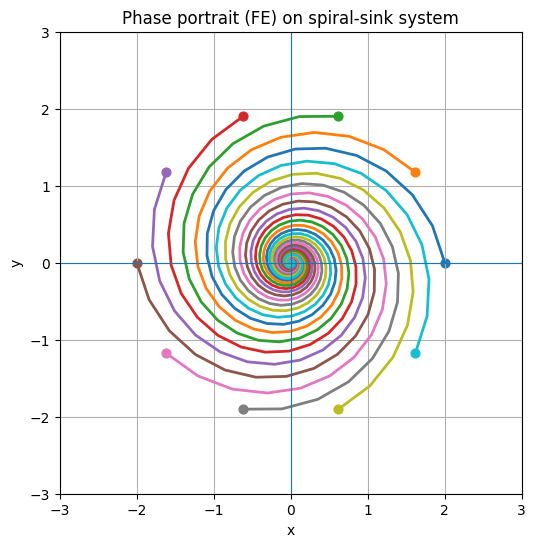

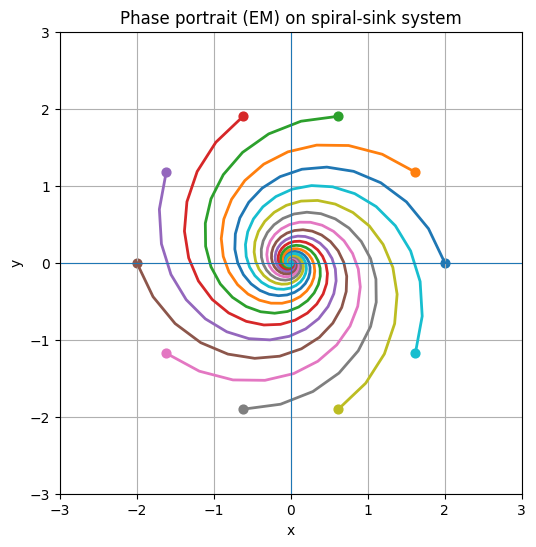

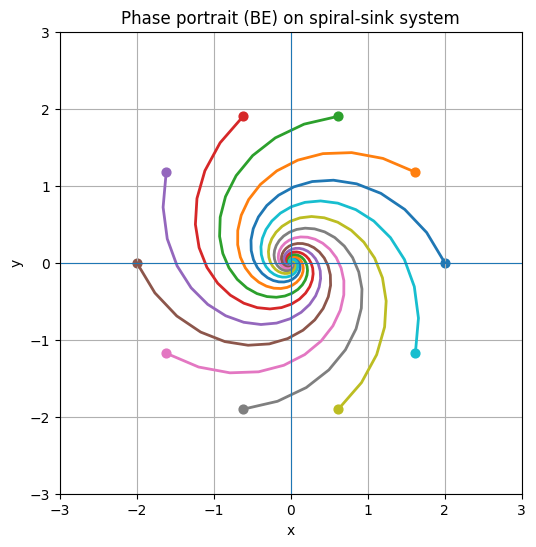

In [14]:
A = A_spiral_sink
inits = circle_initials(radius=2.0, k=10)

for method in ["FE", "EM", "BE"]:
    plot_phase_portrait(
        A, initials=inits, h=0.08, T=8.0, method=method,
        xlim=(-3, 3), ylim=(-3, 3),
        title=f"Phase portrait ({method}) on spiral-sink system"
    )

## 6) Amplification matrices and stability (linear systems)

For $\mathbf{x}' = A\mathbf{x}$, each method can be written as

$$\mathbf{x}_{n+1} = G\,\mathbf{x}_n$$
where \(G\) is the **amplification matrix**:

- Forward Euler: $G_{\mathrm{FE}} = I + hA$
- Explicit Midpoint: $G_{\mathrm{EM}} = I + hA + \tfrac12(hA)^2$
- Backward Euler: $G_{\mathrm{BE}} = (I - hA)^{-1}$

A practical check: compute eigenvalues $\mu$ of $G$ and look at $|\mu|$.

In [15]:
def amplification_matrix(A, h, method="FE"):
    A = torch.as_tensor(A, dtype=torch.get_default_dtype())
    d = A.shape[0]
    I = torch.eye(d, dtype=torch.get_default_dtype())

    if method == "FE":
        return I + h * A
    if method == "EM":
        return I + h * A + 0.5 * (h * A) @ (h * A)
    if method == "BE":
        return torch.linalg.inv(I - h * A)
    raise ValueError("method must be 'FE', 'EM', or 'BE'")

def spectral_radius(M):
    mu = torch.linalg.eigvals(M)
    return torch.max(torch.abs(mu)).item(), mu

A = A_stable
for method in ["FE", "EM", "BE"]:
    for h in [0.2, 0.8, 1.2]:
        G = amplification_matrix(A, h, method)
        rho, mu = spectral_radius(G)
        print(f"method={method:>2}, h={h:>4.2f}, spectral_radius={rho:.4f}, eig(G)={mu}")

method=FE, h=0.20, spectral_radius=0.8000, eig(G)=tensor([0.8000+0.j, 0.6000+0.j])
method=FE, h=0.80, spectral_radius=0.6000, eig(G)=tensor([ 0.2000+0.j, -0.6000+0.j])
method=FE, h=1.20, spectral_radius=1.4000, eig(G)=tensor([-0.2000+0.j, -1.4000+0.j])
method=EM, h=0.20, spectral_radius=0.8200, eig(G)=tensor([0.8200+0.j, 0.6800+0.j])
method=EM, h=0.80, spectral_radius=0.6800, eig(G)=tensor([0.5200+0.j, 0.6800+0.j])
method=EM, h=1.20, spectral_radius=1.4800, eig(G)=tensor([0.5200+0.j, 1.4800+0.j])
method=BE, h=0.20, spectral_radius=0.8333, eig(G)=tensor([0.8333+0.j, 0.7143+0.j])
method=BE, h=0.80, spectral_radius=0.5556, eig(G)=tensor([0.5556+0.j, 0.3846+0.j])
method=BE, h=1.20, spectral_radius=0.4545, eig(G)=tensor([0.4545+0.j, 0.2941+0.j])


## 7) Stability regions in the complex plane

For the scalar test equation $x' = \lambda x$, define $z = h\lambda$.
Each method has a stability function $R(z)$:

- FE: $R(z)=1+z$
- EM: $R(z)=1+z+\tfrac{1}{2}z^2$
- BE: $R(z)=\frac{1}{1-z}$

The stability region is $\{z\in\mathbb{C}: |R(z)|<1\}$.

For systems $\mathbf{x}'=A\mathbf{x}$, the eigenvalues $\lambda_k$ of $A$ behave like separate modes,
so we check whether each $z_k=h\lambda_k$ lies inside the stability region.

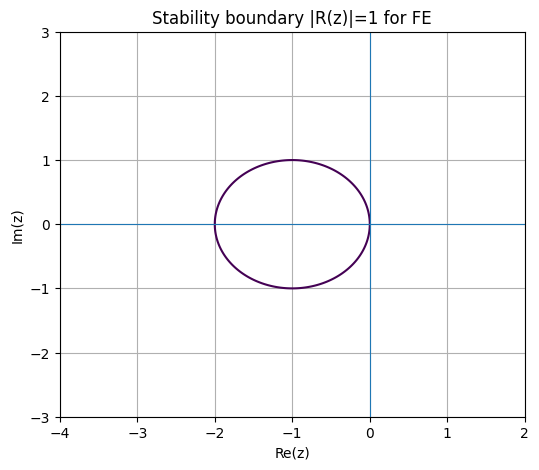

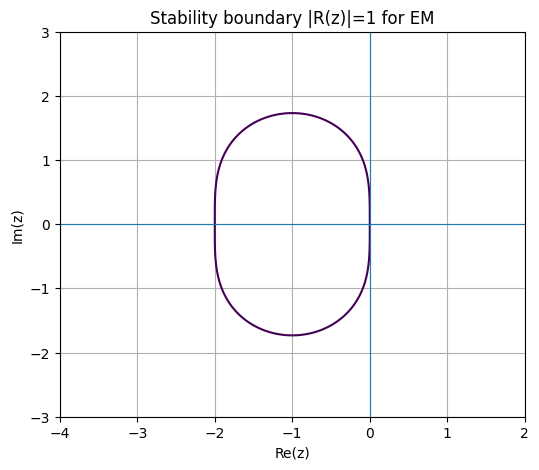

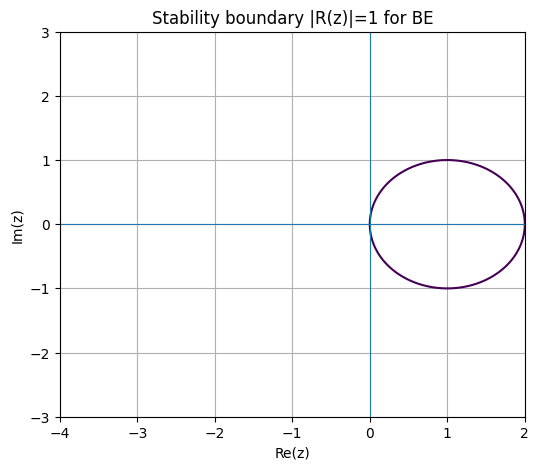

In [16]:
def R(z, method):
    if method == "FE":
        return 1 + z
    if method == "EM":
        return 1 + z + 0.5 * z**2
    if method == "BE":
        return 1 / (1 - z)
    raise ValueError("method must be FE/EM/BE")

def plot_stability_boundary(method="FE", xlim=(-4, 2), ylim=(-3, 3), grid=400):
    xr = np.linspace(xlim[0], xlim[1], grid)
    yi = np.linspace(ylim[0], ylim[1], grid)
    X, Y = np.meshgrid(xr, yi)
    Z = X + 1j * Y
    M = np.abs(R(Z, method))

    plt.figure(figsize=(6, 5))
    plt.contour(X, Y, M, levels=[1.0])
    plt.axhline(0, linewidth=0.8)
    plt.axvline(0, linewidth=0.8)
    plt.xlabel("Re(z)")
    plt.ylabel("Im(z)")
    plt.title(f"Stability boundary |R(z)|=1 for {method}")
    plt.grid(True)
    plt.show()

def overlay_h_lambda(A, h, method="FE", xlim=(-6, 2), ylim=(-6, 6), grid=400):
    A = torch.as_tensor(A, dtype=torch.get_default_dtype())
    eigs = torch.linalg.eigvals(A).cpu().numpy()
    z = h * eigs

    xr = np.linspace(xlim[0], xlim[1], grid)
    yi = np.linspace(ylim[0], ylim[1], grid)
    X, Y = np.meshgrid(xr, yi)
    Z = X + 1j * Y
    M = np.abs(R(Z, method))

    plt.figure(figsize=(6, 5))
    plt.contour(X, Y, M, levels=[1.0])
    plt.scatter(z.real, z.imag, s=80)
    for k, zk in enumerate(z):
        plt.text(zk.real, zk.imag, f"  z{k+1}", fontsize=10)
    plt.axhline(0, linewidth=0.8)
    plt.axvline(0, linewidth=0.8)
    plt.xlabel("Re(z)")
    plt.ylabel("Im(z)")
    plt.title(f"{method}: boundary + z_k=h*lambda_k (h={h})")
    plt.grid(True)
    plt.show()

for method in ["FE", "EM", "BE"]:
    plot_stability_boundary(method=method)

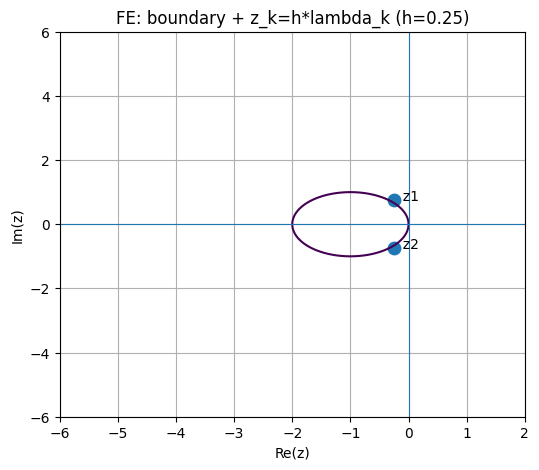

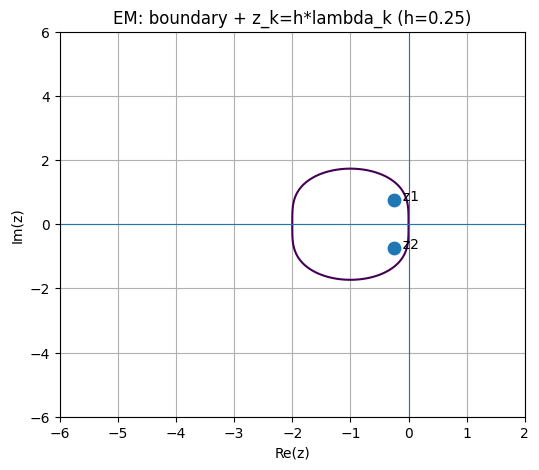

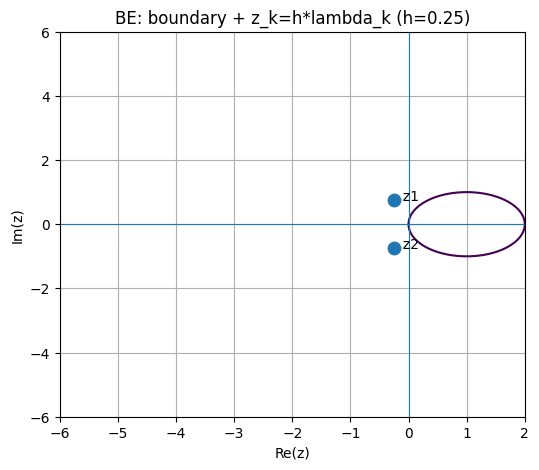

In [17]:
# Overlay stability for a system with complex eigenvalues
A = A_spiral_sink
h = 0.25  # try changing this

for method in ["FE", "EM", "BE"]:
    overlay_h_lambda(A, h=h, method=method, xlim=(-6, 2), ylim=(-6, 6))

## 8) Mini-exercises (recommended)

1. Change `A_spiral_sink` to make the real part positive (spiral source). What happens to trajectories?
2. For the saddle matrix, try FE with different `h`. Does it ever look “stable”?
3. Create a stiff system: eigenvalues \(-1\) and \(-50\).  
   - How small must `h` be for FE to behave?
   - Does BE remain stable for larger `h`?
4. For a given \(A\), compute \(G\) and eigenvalues of \(G\) directly. Compare with the stability-region plot.

If you want, we can extend this notebook to:
- 3D systems (3 variables) with 3D trajectory plots
- nonlinear systems
- Newton iterations for Backward Euler on nonlinear systems